In [1]:
import sys
sys.path.append("..")

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import seaborn as sns # conda install seaborn
import pandas as pd # ^^ this will automatically install pandas

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sghmc import SGHMC
from kernel.sgld import SGLD
from kernel.sgd import SGD
from kernel.sgnuts import NUTS as SGNUTS

pyro.set_rng_seed(101)

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [3]:
BATCH_SIZE = 500
NUM_EPOCHS = 10
WARMUP_EPOCHS = 0
HIDDEN_SIZE = 100

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]
    
mean = 0.1307
std = 0.3081

# scale and normalise the datasets
X_train = train_dataset.data[train_idx] / 255.0
Y_train = train_dataset.targets[train_idx]

X_val = train_dataset.data[val_idx] / 255.0 
Y_val = train_dataset.targets[val_idx]

X_test = (test_dataset.data / 255.0 - mean) / std
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size, prec=1.):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting
        
        # TODO add gamma priors to precision terms
        self.fc1 = PyroLinear(input_size, hidden_size)
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size]).to_event(1))
        
        self.fc2 = PyroLinear(hidden_size, output_size)
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size, hidden_size]).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size]).to_event(1))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

In [6]:
LR = 8e-6
MOMENTUM_DECAY = 0.1
RESAMPLE_EVERY_N = 100
NUM_STEPS = 1

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sghmc_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        sghmc_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 31.71it/s, lr=8.00e-06]


Epoch [1/10] test accuracy: 0.6154 time: 4.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.61it/s, lr=8.00e-06]


Epoch [2/10] test accuracy: 0.7164 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.94it/s, lr=8.00e-06]


Epoch [3/10] test accuracy: 0.7720 time: 4.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.42it/s, lr=8.00e-06]


Epoch [4/10] test accuracy: 0.8059 time: 4.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=8.00e-06]


Epoch [5/10] test accuracy: 0.8236 time: 4.68


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.93it/s, lr=8.00e-06]


Epoch [6/10] test accuracy: 0.8432 time: 4.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.08it/s, lr=8.00e-06]


Epoch [7/10] test accuracy: 0.8584 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.05it/s, lr=8.00e-06]


Epoch [8/10] test accuracy: 0.8707 time: 4.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.00it/s, lr=8.00e-06]


Epoch [9/10] test accuracy: 0.8818 time: 4.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=8.00e-06]


Epoch [10/10] test accuracy: 0.8894 time: 4.41


In [7]:
LR = 2e-5
NOISE_RATE = 2*LR
NUM_STEPS = 1

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sgld = SGLD(bnn,
            subsample_positions=[0, 1],
            batch_size=BATCH_SIZE,
            learning_rate=LR,
            noise_rate=NOISE_RATE,
            num_steps=NUM_STEPS)

sgld_mcmc = MCMC(sgld, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sgld_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sgld_mcmc.run(X_train, Y_train)
    sgld_samples = sgld_mcmc.get_samples()
    
    if epoch >= WARMUP_EPOCHS:
        
        start = time.time()
        sgld_samples = sgld_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sgld_samples)
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
            
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        sgld_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.97it/s, lr=2.00e-05]


Epoch [1/10] test accuracy: 0.5821 time: 4.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.18it/s, lr=2.00e-05]


Epoch [2/10] test accuracy: 0.6852 time: 4.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=2.00e-05]


Epoch [3/10] test accuracy: 0.7473 time: 4.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.13it/s, lr=2.00e-05]


Epoch [4/10] test accuracy: 0.7830 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.79it/s, lr=2.00e-05]


Epoch [5/10] test accuracy: 0.8091 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-05]


Epoch [6/10] test accuracy: 0.8239 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.97it/s, lr=2.00e-05]


Epoch [7/10] test accuracy: 0.8347 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-05]


Epoch [8/10] test accuracy: 0.8452 time: 4.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-05]


Epoch [9/10] test accuracy: 0.8508 time: 4.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-05]


Epoch [10/10] test accuracy: 0.8581 time: 4.39


In [8]:
LR = 6e-5
WEIGHT_DECAY=0.0
WITH_MOMENTUM=False
MOMENTUM_DECAY=1.0
REGULARIZATION_TERM=1.

bnn = BNN(28*28, HIDDEN_SIZE, 10, prec=REGULARIZATION_TERM)

sgd = SGD(bnn,
          subsample_positions=[0, 1],
          batch_size=BATCH_SIZE,
          learning_rate=LR,
          weight_decay=WEIGHT_DECAY,
          with_momentum=WITH_MOMENTUM,
          momentum_decay=MOMENTUM_DECAY)

sgd_mcmc = MCMC(sgd, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sgd_test_errs = []

for epoch in range(1, 1+NUM_EPOCHS+WARMUP_EPOCHS):
    sgd_mcmc.run(X_train, Y_train)
        
    if epoch >= WARMUP_EPOCHS:
        
        sgd_samples = sgd_mcmc.get_samples()
        point_estimate = {site : sgd_samples[site][-1, :].unsqueeze(0) for site in sgd_samples.keys()}
        predictive = pyro.infer.Predictive(bnn, posterior_samples=point_estimate)
        start = time.time()
        
        with torch.no_grad():
            total = 0
            correct = 0
            for x, y in val_loader:
                batch_predictive = predictive(x)['obs']
                batch_y_hat = batch_predictive.mode(0)[0]
                total += y.shape[0]
                correct += int((batch_y_hat == y).sum())
            
        end = time.time()
        
        sgd_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.41it/s, lr=6.00e-05]


Epoch [1/10] test accuracy: 0.3691 time: 0.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.88it/s, lr=6.00e-05]


Epoch [2/10] test accuracy: 0.5532 time: 0.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.48it/s, lr=6.00e-05]


Epoch [3/10] test accuracy: 0.6337 time: 0.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=6.00e-05]


Epoch [4/10] test accuracy: 0.6519 time: 0.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.61it/s, lr=6.00e-05]


Epoch [5/10] test accuracy: 0.6494 time: 0.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.43it/s, lr=6.00e-05]


Epoch [6/10] test accuracy: 0.6760 time: 0.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.33it/s, lr=6.00e-05]


Epoch [7/10] test accuracy: 0.6897 time: 0.42


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.63it/s, lr=6.00e-05]


Epoch [8/10] test accuracy: 0.6953 time: 0.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.30it/s, lr=6.00e-05]


Epoch [9/10] test accuracy: 0.6942 time: 0.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=6.00e-05]


Epoch [10/10] test accuracy: 0.6358 time: 0.32


In [9]:
LR = 8e-4
WEIGHT_DECAY=1e-6
WITH_MOMENTUM=True
MOMENTUM_DECAY=0.01
REGULARIZATION_TERM=1.

bnn = BNN(28*28, HIDDEN_SIZE, 10, prec=REGULARIZATION_TERM)

sgdmom = SGD(bnn,
             subsample_positions=[0, 1],
             batch_size=BATCH_SIZE,
             learning_rate=LR,
             weight_decay=WEIGHT_DECAY,
             with_momentum=WITH_MOMENTUM,
             momentum_decay=MOMENTUM_DECAY)

sgdmom_mcmc = MCMC(sgdmom, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sgdmom_test_errs = []

for epoch in range(1, 1+NUM_EPOCHS+WARMUP_EPOCHS):
    sgdmom_mcmc.run(X_train, Y_train)
        
    if epoch >= WARMUP_EPOCHS:
        
        sgdmom_samples = sgdmom_mcmc.get_samples()
        point_estimate = {site : sgdmom_samples[site][-1, :].unsqueeze(0) for site in sgdmom_samples.keys()}
        predictive = pyro.infer.Predictive(bnn, posterior_samples=point_estimate)
        start = time.time()
        
        with torch.no_grad():
            total = 0
            correct = 0
            for x, y in val_loader:
                batch_predictive = predictive(x)['obs']
                batch_y_hat = batch_predictive.mode(0)[0]
                total += y.shape[0]
                correct += int((batch_y_hat == y).sum())
            
        end = time.time()
        
        sgdmom_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.83it/s, lr=8.00e-04]


Epoch [1/10] test accuracy: 0.7337 time: 0.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.90it/s, lr=8.00e-04]


Epoch [2/10] test accuracy: 0.6902 time: 0.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.83it/s, lr=8.00e-04]


Epoch [3/10] test accuracy: 0.7670 time: 0.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.14it/s, lr=8.00e-04]


Epoch [4/10] test accuracy: 0.7973 time: 0.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.22it/s, lr=8.00e-04]


Epoch [5/10] test accuracy: 0.8305 time: 0.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.84it/s, lr=8.00e-04]


Epoch [6/10] test accuracy: 0.8380 time: 0.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=8.00e-04]


Epoch [7/10] test accuracy: 0.8472 time: 0.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 57.79it/s, lr=8.00e-04]


Epoch [8/10] test accuracy: 0.8504 time: 0.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.73it/s, lr=8.00e-04]


Epoch [9/10] test accuracy: 0.8589 time: 0.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.49it/s, lr=8.00e-04]


Epoch [10/10] test accuracy: 0.8689 time: 0.30


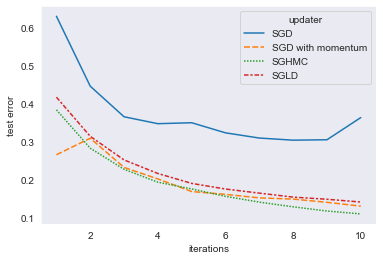

In [10]:
sns.set_style("dark")
    
sghmc_test_errs = np.array(sghmc_test_errs)
sgld_test_errs = np.array(sgld_test_errs)
sgd_test_errs = np.array(sgd_test_errs)
sgdmom_test_errs = np.array(sgdmom_test_errs)

err_dict = {'SGHMC' : sghmc_test_errs, 'SGLD' : sgld_test_errs, 'SGD' : sgd_test_errs, 'SGD with momentum' : sgdmom_test_errs}
x = np.arange(1, NUM_EPOCHS+1)
lst = []
for i in range(len(x)):
    for updater in err_dict.keys():
        lst.append([x[i], updater, err_dict[updater][i]])

df = pd.DataFrame(lst, columns=['iterations', 'updater','test error'])
sns.lineplot(data=df.pivot("iterations", "updater", "test error"))
plt.ylabel("test error")
plt.show() #dpi=300

In [11]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
NUM_STEPS = 1

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sgnuts = SGNUTS(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              with_friction=True,
              obs_info_noise=False)

sgnuts_mcmc = MCMC(sgnuts, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)
# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sgnuts_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sgnuts_samples = sgnuts_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sgnuts_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int8)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int8)), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Warmup:   0%|                                                                                    | 0/100 [00:00, ?it/s]

ValueError: only one element tensors can be converted to Python scalars